## KAN Regression

cuda


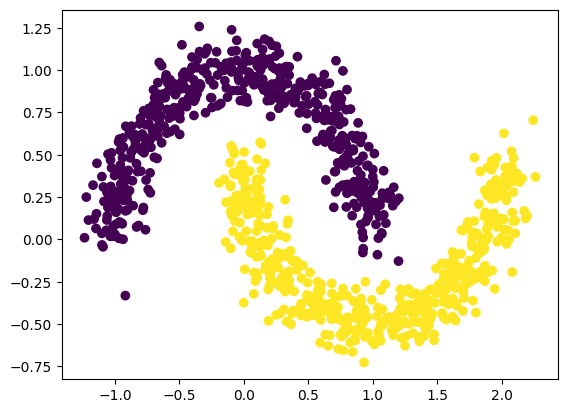

In [15]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

In [22]:
dataset["train_input"].shape

torch.Size([1000, 2])

In [16]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 1.56e-01 | reg: 3.93e+00 | : 100%|█| 20/20 [00:01<00:00, 18.86it

saving model version 0.1


(0.999000072479248, 0.9980000257492065)

In [24]:
results.keys()

dict_keys(['train_loss', 'test_loss', 'reg', 'train_acc', 'test_acc'])

In [18]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
# ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9681435823440552, c=2
fixing (0,1,0) with x, r2=0.9766705632209778, c=1
saving model version 0.2


In [25]:
formula

-0.858788314512566*x_2 - 0.382751107215881*sin(3.09135985374451*x_1 + 4.74376010894775) + 0.706984093326383

In [19]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9980, device='cuda:0')
test acc of the formula: tensor(0.9970, device='cuda:0')


## KAN Classification

Documentation: https://kindxiaoming.github.io/pykan/index.html

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 0.00e+00 | test_loss: 8.36e-02 | reg: 3.55e+02 | : 100%|█| 50/50 [00:02<00:00, 21.53it


saving model version 0.1
train acc of the formula: tensor(0.5000)
test acc of the formula: tensor(0.5000)


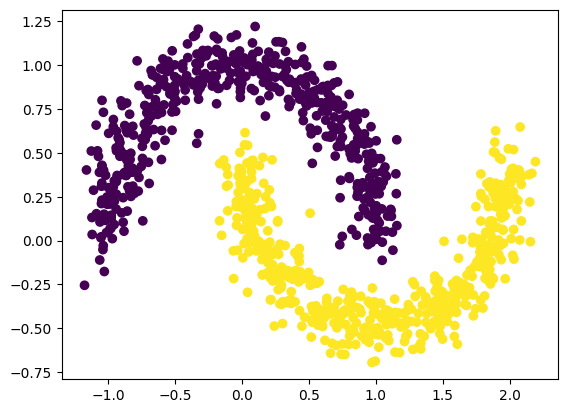

In [22]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
dtype = torch.float32
device = torch.device("cpu")
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

formula1, formula2 = model.symbolic_formula()[0]
print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

In [20]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
# ex_round(formula1, 4)

fixing (0,0,0) with x, r2=0.13109275698661804, c=1
fixing (0,0,1) with x, r2=0.10080759227275848, c=1
fixing (0,1,0) with x, r2=0.8944054841995239, c=1
fixing (0,1,1) with x, r2=0.9020138382911682, c=1
saving model version 0.2


In [21]:
model.symbolic_formula()

([-81.496996196438*x_1 + 560.475343511614*x_2 - 37.8952878347573,
  62.5668641808261*x_1 - 481.274174586226*x_2 + 36.7315063932983],
 [x_1, x_2])

In [18]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8850)
test acc of the formula: tensor(0.8810)


## KAN Pruning

checkpoint directory created: ./model
saving model version 0.0


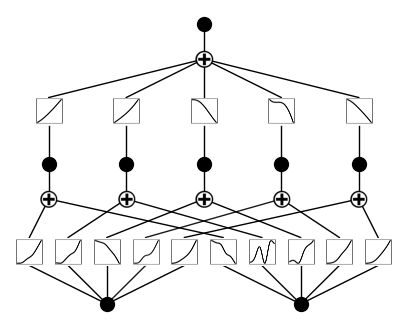

In [54]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

# plot KAN at initialization
# Model has to see data to be able to be plotted
model(dataset['train_input'])
model.plot(beta=100)

| train_loss: 1.75e-01 | test_loss: 1.78e-01 | reg: 1.89e+01 | : 100%|█| 20/20 [00:06<00:00,  3.12it


saving model version 0.1


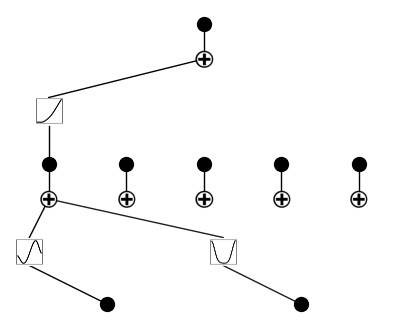

In [ ]:
# train the model with auto pruning
result = model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)
model.plot()

saving model version 0.2


| train_loss: 7.30e-03 | test_loss: 7.24e-03 | reg: 7.61e+00 | : 100%|█| 50/50 [00:06<00:00,  8.02it


saving model version 0.3


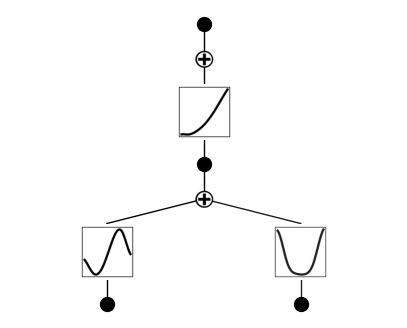

In [ ]:
# Prune the model and visualize, make sure the model sees the data
model = model.prune()
model(dataset['train_input'])
model.plot()

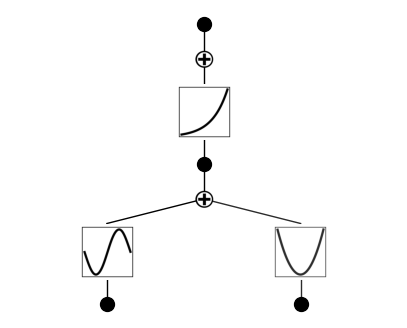

In [ ]:
# Fit the data again using the pruned model
result_pruned = model.fit(dataset, opt="LBFGS", steps=50);
model.plot()

In [ ]:
# Use symbolic functions to fix originally learned activation functon (splines)
# And then fit the model on the data again

mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

result_symbol = model.fit(dataset, opt="LBFGS", steps=50);
model.symbolic_formula()[0][0]

fixing (0,0,0) with sin, r2=0.9999728798866272, c=2
fixing (0,1,0) with x^2, r2=0.9999991655349731, c=2
fixing (1,0,0) with exp, r2=0.9999989867210388, c=2
saving model version 0.4


## Serious KAN